In [2]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
from scipy import stats
%reload_ext pandas_tutor
%set_pandas_tutor_options {'projectorMode': True}
set_matplotlib_formats("svg")
plt.style.use('fivethirtyeight')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

# Demonstration code
def r_scatter(r):
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r * x + (np.sqrt(1 - r ** 2)) * z
    plt.scatter(x, y)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    
def show_scatter_grid():
    plt.subplots(1, 4, figsize=(10, 2))
    for i, r in enumerate([-1, -2/3, -1/3, 0]):
        plt.subplot(1, 4, i+1)
        r_scatter(r)
        plt.title(f'r = {np.round(r, 2)}')
    plt.show()
    plt.subplots(1, 4, figsize=(10, 2))
    for i, r in enumerate([1, 2/3, 1/3]):
        plt.subplot(1, 4, i+1)
        r_scatter(r)
        plt.title(f'r = {np.round(r, 2)}')
    plt.subplot(1, 4, 4)
    plt.axis('off')
    plt.show()

# Lecture 24 – Prediction and Correlation

## DSC 10, Summer 2022

### Announcements

- Homework 7 is due **Sat at 11:59pm**.
- Lab 8 is due on **Tues at 11:59pm**.
- The Final Project is due on **Wednesday 8/31 at 11:59pm**
    - Start if you haven't already!

### Agenda

- Prediction.
- Correlation.
- Regression.

## Prediction

### Prediction

- Suppose we have a dataset with at least two variables, e.g. education level and income.
- We're interested in **predicting** the future – predicting one variable based on another:
    - Given my education level, what is my income?
    - Given my height, how tall will my kid be as an adult?
    - Given the difficulty of a recipe, how many dirty dishes will it create? 
- To do this, we need to first observe a pattern between the two variables.

### Association

- An **association** is any link or relationship between two variables in a scatter plot.
- Associations can be linear or non-linear.
- If two variables have a positive association, then as one variable increases, the other tends to increase.
- If two variables have a negative association, then as one variable increases, the other tends to decrease.
- As we saw earlier in the quarter, association $\neq$ causation!
    - But, just an association is enough to let us make predictions.

### Example: hybrid cars

In [3]:
hybrid = bpd.read_csv('data/hybrid.csv')
hybrid

,vehicle,year,msrp,acceleration,mpg,class
0,Prius (1st Gen),1997,24509.74,7.46,41.26,Compact
1,Tino,2000,35354.97,8.20,54.10,Compact
2,Prius (2nd Gen),2000,26832.25,7.97,45.23,Compact
...,...,...,...,...,...,...
150,C-Max Energi Plug-in,2013,32950.00,11.76,43.00,Midsize
151,Fusion Energi Plug-in,2013,38700.00,11.76,43.00,Midsize
152,Chevrolet Volt,2013,39145.00,11.11,37.00,Compact


### `'acceleration'` and `'msrp'`
- Is there an association?
- What kind of association?

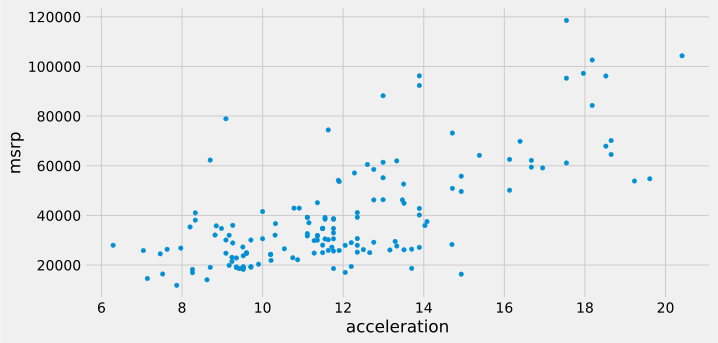

In [4]:
hybrid.plot(kind='scatter', x='acceleration', y='msrp', figsize=(10, 5));

### `'mpg'` and `'msrp'`

- Is there an association?
- What kind of association?

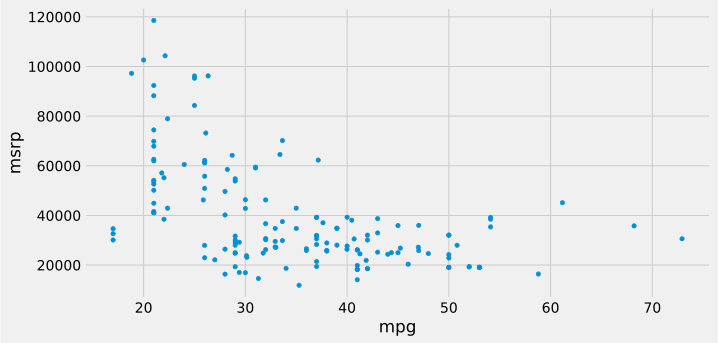

In [5]:
hybrid.plot(kind='scatter', x='mpg', y='msrp', figsize=(10, 5));

**Observations:**
- There is an association – cars with better fuel economy tended to be cheaper.
    - Why is that? 🤔
- The association looks more curved than linear. 
    - It may roughly follow $y \approx \frac{1}{x}$.
   

### Understanding units
- A linear change in units doesn't change the shape of the plot, it only changes the scale of the plot.
    - Linear change means adding or subtracting a constant, and multiplying or dividing by a constant.
- In other words, instead of plotting price in _dollars_ and fuel economy in _MPG_, we can plot price in _Euros_ and fuel economy in _kilometers per liter_ and the plot would look the same, just with different axes:

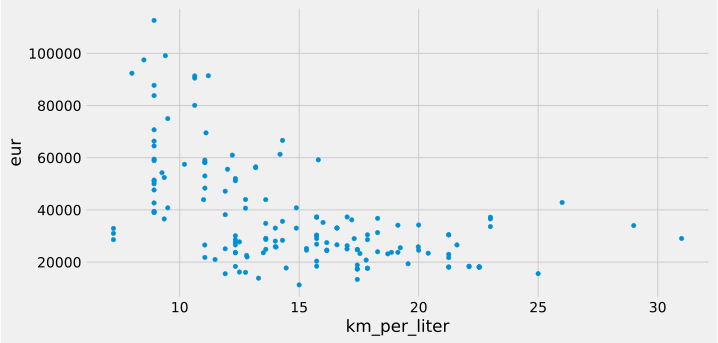

In [6]:
hybrid.assign(
        km_per_liter=hybrid.get('mpg') * 0.425144,
        eur=hybrid.get('msrp') * 0.95 
).plot(kind='scatter', x='km_per_liter', y='eur', figsize=(10, 5));

### Converting columns to standard units
- Recall: to convert $x$ to standard units, we compute

$$z(x) = \frac{x - \text{mean of all $x$s}}{\text{SD of all $x$s}}$$

- Converting columns to standard units makes different scatter plots comparable, by making the $x$ and $y$ axes "similarly scaled."
    - Both axes measure the number of standard deviations a data point is above or below its mean.
- Converting columns to standard units doesn't change shape of the scatter plot (the conversion is linear).

### You Try: Standard Units

Fill in the function `standard_units`. It takes in an array of numbers and returns the array converted to standard units.

Afetr writing `standard_units`, the `standardize` function should work.

In [16]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - any_numbers.mean()) / np.std(any_numbers)

In [17]:
def standardize(df):
    """Return a DataFrame in which all columns of df are converted to standard units."""
    df_su = bpd.DataFrame()
    for column in df.columns:
        df_su = df_su.assign(**{column + ' (su)': standard_units(df.get(column))})
    return df_su

In [18]:
# If your code is right, this cell should output a dataframe with the
# standardized acceleration and msrp columns
standardize(hybrid.get(['acceleration', 'msrp']))

,acceleration (su),msrp (su)
0,-1.54,-6.94e-01
1,-1.28,-1.86e-01
2,-1.36,-5.85e-01
...,...,...
150,-0.07,-2.98e-01
151,-0.07,-2.90e-02
152,-0.29,-8.17e-03


### Standard units for hybrid cars
For a given pair of variables:
- Which cars are average from both perspectives?
- Which cars are both well above/below average?

In [20]:
hybrid_su = (standardize(hybrid.get(['msrp', 'acceleration', 'mpg']))
             .assign(vehicle=hybrid.get('vehicle'))
            )
hybrid_su

,msrp (su),acceleration (su),mpg (su),vehicle
0,-6.94e-01,-1.54,0.59,Prius (1st Gen)
1,-1.86e-01,-1.28,1.76,Tino
2,-5.85e-01,-1.36,0.95,Prius (2nd Gen)
...,...,...,...,...
150,-2.98e-01,-0.07,0.75,C-Max Energi Plug-in
151,-2.90e-02,-0.07,0.75,Fusion Energi Plug-in
152,-8.17e-03,-0.29,0.20,Chevrolet Volt


### `'acceleration'` and `'msrp'`

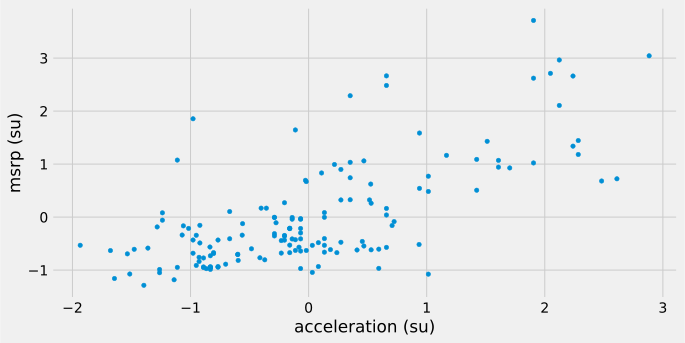

In [21]:
hybrid_su.plot(kind='scatter', x='acceleration (su)', y='msrp (su)', figsize=(10, 5));

Which cars have `'acceleration'`s and `'msrp'`s that are more than 2 SDs above average?

In [22]:
hybrid_su[(hybrid_su.get('acceleration (su)') > 2) &
          (hybrid_su.get('msrp (su)') > 2)]

,msrp (su),acceleration (su),mpg (su),vehicle
47,2.71,2.05,-1.46,ActiveHybrid X6
60,3.04,2.88,-1.16,ActiveHybrid 7
95,2.96,2.12,-1.35,ActiveHybrid 7i
146,2.11,2.12,-0.90,ActiveHybrid 7L
147,2.66,2.24,-0.90,Panamera S


### `'mpg'` and `'msrp'`

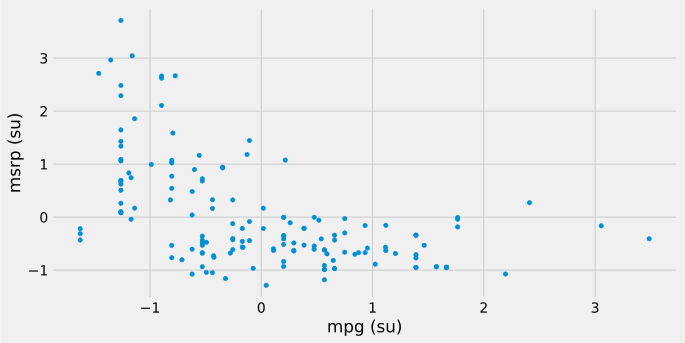

In [23]:
hybrid_su.plot(kind='scatter', x='mpg (su)', y='msrp (su)', figsize=(10, 5));

Which cars have close to average `'mpg'`s and close to average `'msrp'`s?

In [24]:
hybrid_su[(hybrid_su.get('mpg (su)') <= 0.3) &
          (hybrid_su.get('mpg (su)') >= -0.3) &
          (hybrid_su.get('msrp (su)') <= 0.3) &
          (hybrid_su.get('msrp (su)') >= -0.3)]

,msrp (su),acceleration (su),mpg (su),vehicle
10,-1.24e-01,-0.56,-0.26,Escape
22,-2.13e-01,-1.02,-0.17,Mercury Mariner
57,-8.47e-02,0.72,-0.11,Audi Q5
...,...,...,...,...
70,-2.14e-01,-0.07,0.02,HS 250h
102,-2.69e-03,-0.29,0.20,Chevrolet Volt
152,-8.17e-03,-0.29,0.20,Chevrolet Volt


### Observation on associations in standard units
- If two variables are positively associated,
    - their high, positive values in standard units are typically seen together, and
    - their low, negative values are seen together as well.
- If two variables are negatively associated,
    - high, positive values of one are typically coupled with low, negative values of the other.
- If two variables aren't associated, there should be no such pattern.

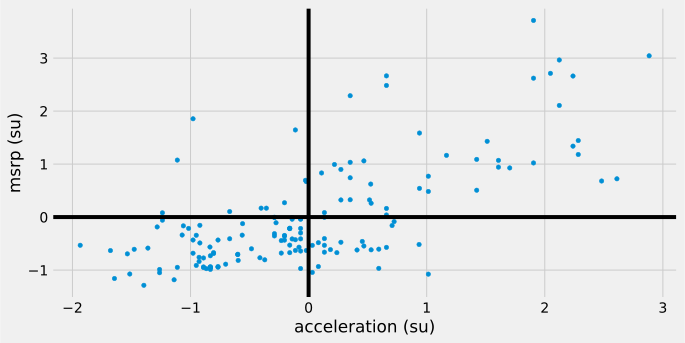

In [25]:
hybrid_su.plot(kind='scatter', x='acceleration (su)', y='msrp (su)', figsize=(10, 5))
plt.axvline(0, color='black');
plt.axhline(0, color='black');

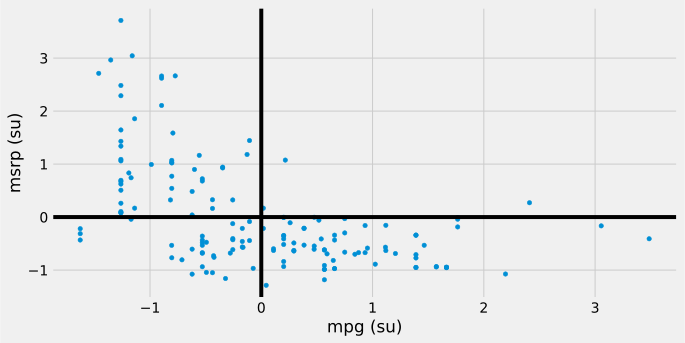

In [26]:
hybrid_su.plot(kind='scatter', x='mpg (su)', y='msrp (su)', figsize=(10, 5))
plt.axvline(0, color='black');
plt.axhline(0, color='black');

## Correlation

### Definition: correlation coefficient

**Definition**: The correlation coefficient $r$ of two variables $x$ and $y$ is the 
- **average** value of the 
- **product** of $x$ and $y$
- when both are measured in **standard units**.

If `x` and `y` are two Series or arrays, 
```py
r = (x_su * y_su).mean()
```
where `x_su` and `y_su` are `x` and `y` converted to standard units.

Let's calculate $r$ for `'acceleration'` and `'msrp'`.

In [27]:
hybrid_su

,msrp (su),acceleration (su),mpg (su),vehicle
0,-6.94e-01,-1.54,0.59,Prius (1st Gen)
1,-1.86e-01,-1.28,1.76,Tino
2,-5.85e-01,-1.36,0.95,Prius (2nd Gen)
...,...,...,...,...
150,-2.98e-01,-0.07,0.75,C-Max Energi Plug-in
151,-2.90e-02,-0.07,0.75,Fusion Energi Plug-in
152,-8.17e-03,-0.29,0.20,Chevrolet Volt


In [28]:
r_acc_price = (hybrid_su.get('acceleration (su)') *
               hybrid_su.get('msrp (su)')).mean()
r_acc_price

0.695577899691398

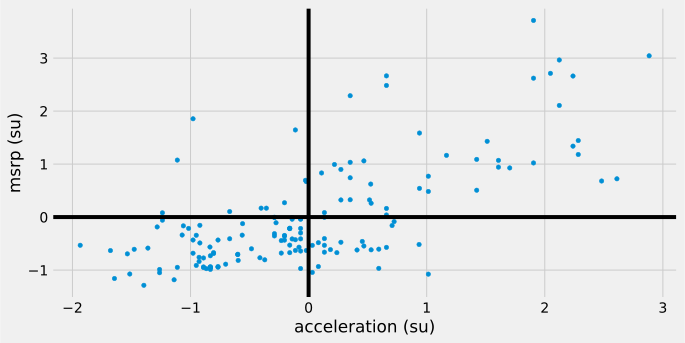

In [29]:
hybrid_su.plot(kind='scatter', x='acceleration (su)', y='msrp (su)', figsize=(10, 5))
plt.axvline(0, color='black');
plt.axhline(0, color='black');

### The correlation coefficient: $r$

- $r$ measures how clustered points are around a straight line – **it measures linear association**.
    - If two variables are correlated, it means they are linearly associated.
- $r$ is always between $-1$ and $1$.
    - If $r = 1$, the scatter plot is a line of slope 1.
    - If $r = -1$, the scatter plot is a line of slope -1.
    - If $r = 0$, there is no linear association (_uncorrelated_).
- $r$ is computed based on standard units.
    - The correlation between price in _dollars_ and fuel economy in _MPG_ is the same as the correlation between price in _Euros_ and fuel economy in _kilometers per liter_.

Let's now calculate $r$ for `'mpg'` and `'msrp'`.

In [30]:
hybrid_su

,msrp (su),acceleration (su),mpg (su),vehicle
0,-6.94e-01,-1.54,0.59,Prius (1st Gen)
1,-1.86e-01,-1.28,1.76,Tino
2,-5.85e-01,-1.36,0.95,Prius (2nd Gen)
...,...,...,...,...
150,-2.98e-01,-0.07,0.75,C-Max Energi Plug-in
151,-2.90e-02,-0.07,0.75,Fusion Energi Plug-in
152,-8.17e-03,-0.29,0.20,Chevrolet Volt


In [31]:
r_mpg_price = (hybrid_su.get('mpg (su)') *
               hybrid_su.get('msrp (su)')).mean()
r_mpg_price

-0.5318263633683789

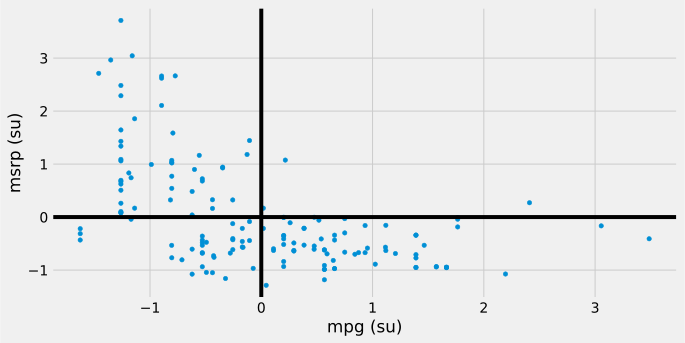

In [32]:
hybrid_su.plot(kind='scatter', x='mpg (su)', y='msrp (su)', figsize=(10, 5));
plt.axvline(0, color='black');
plt.axhline(0, color='black');

### Scatter plots with different correlation coefficients

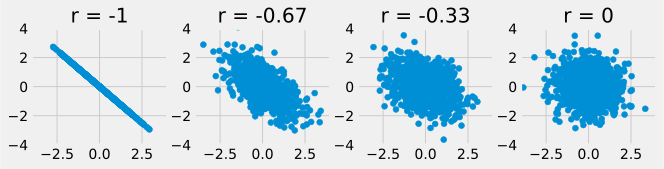

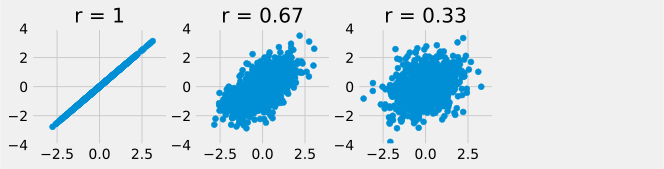

In [33]:
show_scatter_grid()

### Discussion Question

Does this scatter plot show:

- A. Association and correlation?
- B. Association but not correlation?
- C. Correlation but not association?
- D. Neither association nor correlation?

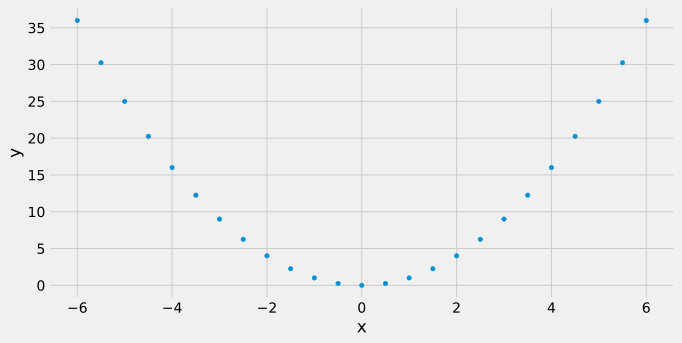

In [34]:
x2 = bpd.DataFrame().assign(
    x=np.arange(-6, 6.1, 0.5), 
    y=np.arange(-6, 6.1, 0.5) ** 2
)
x2.plot(kind='scatter', x='x', y='y', figsize=(10, 5));

### Answer

In [41]:
(standard_units(x2.get('x')) * standard_units(x2.get('y'))).mean()

1.7763568394002505e-17

## Regression

### Goal: predict a child's height from the height of their parents

- Earlier in the quarter, we looked at Galton's method of predicting heights.
    - A child's "midparent" height is a weighted average of the height of their parents.
- Observation: Children of shorter parents tend to be shorter!

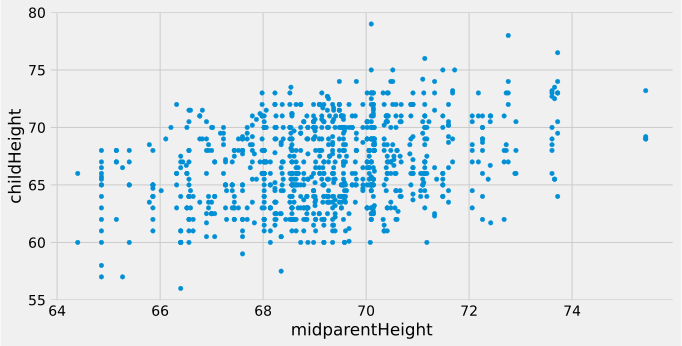

In [42]:
galton = bpd.read_csv('data/galton.csv')
galton.plot(kind='scatter', x='midparentHeight', y='childHeight', figsize=(10, 5));

### Goal: predict a child's height from the height of their parents
Galton's method involved predicting a child's height by
- looking at all midparents within $\pm 0.5$ inches of the child's midparent height and
- averaging the heights of all children of those midparents.

In [43]:
def predict_child(parent_height):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of parent_height.
    """
    close_points = galton[(galton.get('midparentHeight') <= parent_height + 0.5) & 
                          (galton.get('midparentHeight') >= parent_height - 0.5)]
    return close_points.get('childHeight').mean()

with_predictions = galton.assign(
    Prediction=galton.get('midparentHeight').apply(predict_child)
)
with_predictions

,family,father,mother,midparentHeight,...,childNum,gender,childHeight,Prediction
0,1,78.5,67.0,75.43,...,1,male,73.2,70.10
1,1,78.5,67.0,75.43,...,2,female,69.2,70.10
2,1,78.5,67.0,75.43,...,3,female,69.0,70.10
...,...,...,...,...,...,...,...,...,...
931,203,62.0,66.0,66.64,...,3,female,61.0,65.16
932,204,62.5,63.0,65.27,...,1,male,66.5,64.23
933,204,62.5,63.0,65.27,...,2,female,57.0,64.23


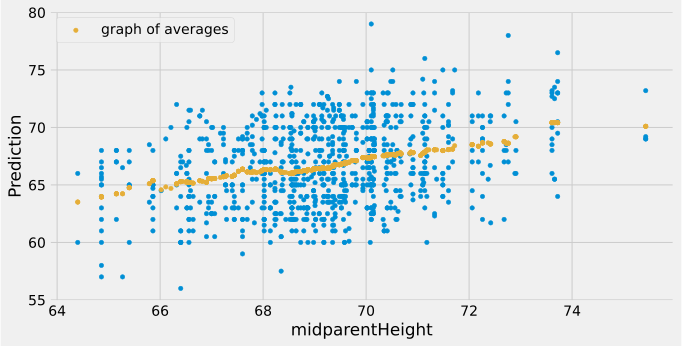

In [44]:
ax = with_predictions.plot(kind='scatter', x='midparentHeight', y='childHeight')
with_predictions.plot(kind='scatter', x='midparentHeight', y='Prediction', ax=ax, color='C2', label="graph of averages", figsize=(10, 5));
plt.legend();

- This is a **graph of averages**.
- We grouped each $x$ value with nearby $x$ values, and averaged the corresponding $y$ values for each group.
- Each gold point corresponds to the predicted $y$ value for each group.
- Notice: the graph of averages looks like a straight line! **Let's try to find that line.**

### Correlation

Let's calculate the correlation between `'midparentHeight'` and `'childHeight'`.

In [47]:
heights_su = standardize(galton.get(['midparentHeight', 'childHeight']))
heights_su

,midparentHeight (su),childHeight (su)
0,3.45,1.80
1,3.45,0.69
2,3.45,0.63
...,...,...
931,-1.42,-1.61
932,-2.19,-0.07
933,-2.19,-2.72


In [49]:
r_mid_child = (heights_su.get('midparentHeight (su)') *
               heights_su.get('childHeight (su)')).mean()
r_mid_child

0.320949896063959

### The regression line

Suppose **$x$ and $y$ are in standard units**, and $r$ is the correlation coefficient between $x$ and $y$. Then, the regression line is defined as follows:

<center><img src='data/regression-line.png' width=400></center>

- The regression line is the line through $(0,0)$ with slope $r$.
- If $x$ and $y$ are linearly associated, then the graph of averages will be very similar to the regression line.
- If the regression line is given by $f(x) = mx + b$, then the prediction for $x$ is given by $f(x)$.

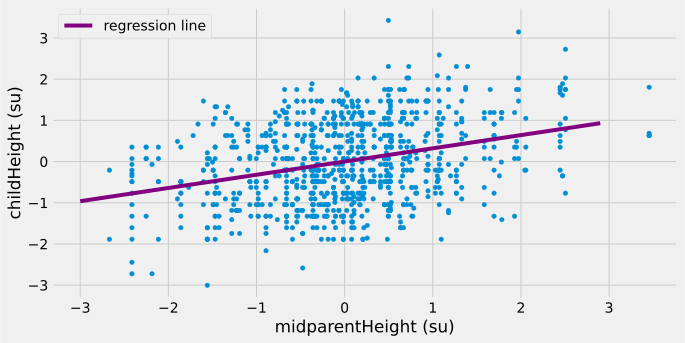

In [50]:
heights_su.plot(kind='scatter', x='midparentHeight (su)', y='childHeight (su)', figsize=(10, 5))
plt.plot(np.arange(-3, 3, 0.1), np.arange(-3, 3, 0.1) * r_mid_child, color='purple', label='regression line');
plt.legend();

### Making predictions in standard units

- If $r = 0.32$, and the given $x$ is 2 in standard units, then:
    - The prediction for $y$ is 0.64 standard units.
    - The regression line predicts that parents whose midparent height is 2 SDs above average have children with whose heights are 0.64 SDs above average.

- **Note:** We predict that a child will be somewhat closer to average than their parents.
    - This is a consequence of the slope ($r$, in this case) having magnitude less than 1.
    - This effect is called **regression to the mean**.

### You Try: Predicting Heights

Of course, we'd like to be able to predict a child's height in original units, not just in standard units. Here's how we'll approach this problem:

1. Convert `'midparentHeight'` to standard units.
2. Use the correlation coefficient to predict `'childHeight'` in standard units.
3. Scale the  predicted `'childHeight'` from standard units back to inches.

Fill in the `predict_with_r` function. It takes in one number (the midparent height) and returns the prediction of the best-fit line.

In [53]:
parent_mean = galton.get('midparentHeight').mean()
parent_sd = np.std(galton.get('midparentHeight'))
child_mean = galton.get('childHeight').mean()
child_sd = np.std(galton.get('childHeight'))

In [54]:
def predict_with_r(parent):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of parent, 
    using linear regression.
    """
    parent_su = (parent - parent_mean) / parent_sd
    child_su = r_mid_child * parent_su
    return child_su * child_sd + child_mean
    

In [55]:
# If you wrote your function right, this line should output 58.33
predict_with_r(56)

58.328450779880555

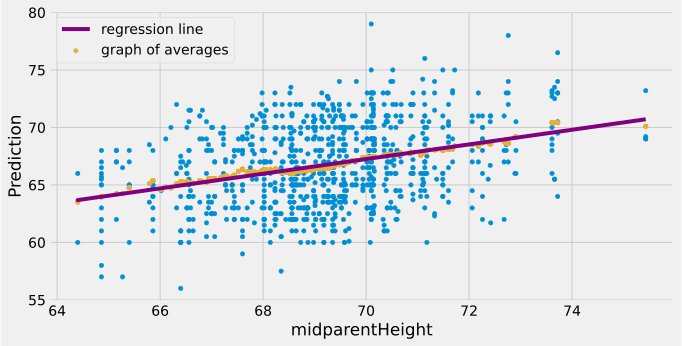

In [56]:
preds = with_predictions.assign(
    Prediction_r=galton.get('midparentHeight').apply(predict_with_r)
)
ax = preds.plot(kind='scatter', x='midparentHeight', y='childHeight', figsize=(10, 5))
preds.plot(kind='scatter', x='midparentHeight', y='Prediction', ax=ax, color='C2', label='graph of averages')
preds.plot(kind='line', x='midparentHeight', y='Prediction_r', ax=ax, color='purple', label='regression line');
plt.legend();

As you can see, the graph of averages and the regression line are pretty similar!

### You Try

A course has a midterm (mean 80, standard deviation 15) and a really hard final (mean 50, standard deviation 12).

If the scatter diagram comparing midterm & final scores for students looks linearly associated with correlation 0.75, then what is the predicted final exam score for a student who received a 90 on the midterm?

## Why does it matter?

- Now, you can fit linear models!
- Linear models seem basic but they're super useful.
    - A modern case study: http://www.textbook.ds100.org/ch/12/pa_intro.html
- Correlation coefficient $r$ actually gives the **best possible** line for the data.
    - We'll see more next time.